In [1]:
import numpy as np
import bokeh.io
import bokeh.plotting

#from scipy.integrate import ode
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


bokeh.io.output_notebook()

Loading BokehJS ...

# Models

In [2]:
def repressilator_model(T, state, *params):
    a,b,c,A,B,C = state
    alpha, alpha0, beta, Kd, delta, delta_m, n = params
    
    # mRNAs
    dadt = alpha/(1 + (C/Kd)**n) + alpha0*alpha - delta_m * a
    dbdt = alpha/(1 + (A/Kd)**n) + alpha0*alpha - delta_m * b
    dcdt = alpha/(1 + (B/Kd)**n) + alpha0*alpha - delta_m * c
    
    # proteins
    dAdt = beta * a - delta * A
    dBdt = beta * b - delta * B
    dCdt = beta * c - delta * C
    
    dstate_dt = [dadt, dbdt, dcdt, dAdt, dBdt, dCdt]
    
    return dstate_dt

In [3]:
def repressilator_model_simple(T, state, *params):   
    A, B, C = state    
    alpha, alpha0, Kd, delta, n = params
    
    # mRNAs
    dAdt = alpha/(1 + (C/Kd)**n) + alpha0*alpha - delta * A
    dBdt = alpha/(1 + (A/Kd)**n) + alpha0*alpha - delta * B
    dCdt = alpha/(1 + (B/Kd)**n) + alpha0*alpha - delta * C
    
    dstate_dt = [dAdt, dBdt, dCdt]
    
    return dstate_dt

# Simulations

In [4]:
def simulate_repressilator(t_end, alpha, alpha0, beta, Kd, delta, delta_m, n, plot_on = False):
    params =  alpha, alpha0, beta, Kd, delta, delta_m, n    
    #print(params)

    # set simulation parameters
    N = t_end*10 # number of samples

    T = np.linspace(0, t_end, N)

    # set initial conditions
    Y0 = np.zeros(6) 
    Y0[0] = 10
    Y0[3] = 5

    sol = solve_ivp(repressilator_model, [0, t_end], Y0, args=params, dense_output=True)
    z = sol.sol(T)
    if plot_on:
        plt.plot(T, z.T)
        plt.legend(['a','b','c','A','B','C'])
        plt.xlabel('Time')
        plt.ylabel('Concentrations')    
        plt.show()
    
    return T, z.T[:,0], z.T[:,1], z.T[:,2], z.T[:,3], z.T[:,4], z.T[:,5]

In [5]:
def simulate_repressilator_simple(t_end, alpha, alpha0, Kd, delta, n):
    params =  alpha, alpha0, Kd, delta, n    

    # set simulation parameters
    N = t_end*10 # number of samples

    T = np.linspace(0, t_end, N)

    # set initial conditions
    Y0 = np.zeros(3)
    Y0[0] = 10
    
    sol = solve_ivp(repressilator_model_simple, [0, t_end], Y0, args=params, dense_output=True)
    z = sol.sol(T)
    plt.plot(T, z.T)
    plt.legend(['A','B','C'])
    plt.xlabel('Time')
    plt.ylabel('Concentrations')
    plt.show()

# Parameters and tests

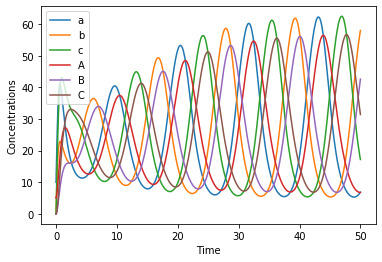

In [6]:
t_end = 50 # simulation duration

alpha = 100
alpha0 = 0.01
beta = 1
Kd = 10
delta = 1
delta_m = 1
n = 2

#alpha_ = alpha*beta/delta_m
#alpha0_ = alpha0*beta/delta_m

t, a, b, c, A, B, C = simulate_repressilator(t_end, alpha, alpha0, beta, Kd, delta, delta_m, n, plot_on=True)

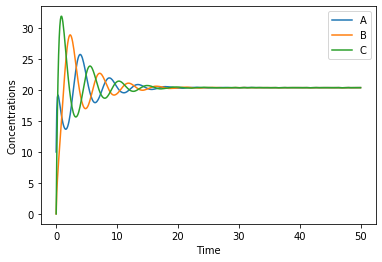

In [7]:
t_end = 50 # simulation duration

alpha = 100
alpha0 = 0.01
Kd = 10
delta = 1
n = 2

#alpha_ = alpha*beta/delta_m
#alpha0_ = alpha0*beta/delta_m

simulate_repressilator_simple(t_end, alpha, alpha0, Kd, delta, n)

# Bokeh

## Sliders

In [8]:
#alpha = 100, alpha0 = 1, beta = 1, Kd = 10, delta = 1, delta_m = 1, n = 2

alpha_slider = bokeh.models.Slider(
    title="alpha",
    start=-3,
    end=3,
    step=0.1,
    value=np.log10(alpha),
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(2)"),
)

alpha0_slider = bokeh.models.Slider(
    title="alpha0",
    start=0,
    end=0.1,
    step=0.001,
    value=alpha0,   
)

beta_slider = bokeh.models.Slider(
    title="beta",
    start=-3,
    end=3,
    step=0.1,
    value=np.log10(beta),
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(2)"),
)

delta_slider = bokeh.models.Slider(
    title="delta",
    start=-4,
    end=4,
    step=0.1,
    value=np.log10(delta),
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(2)"),
)

deltam_slider = bokeh.models.Slider(
    title="delta_m",
    start=-4,
    end=4,
    step=0.1,
    value=np.log10(delta_m),
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(2)"),
)
Kd_slider = bokeh.models.Slider(
    title="Kd",
    start=-4,
    end=4,
    step=0.1,
    value=np.log10(Kd),
    format=bokeh.models.FuncTickFormatter(code="return Math.pow(10, tick).toFixed(2)")
)
n_slider = bokeh.models.Slider(title="n", start=1, end=5, step=0.1, value=n)

## Plotting

In [9]:
cds = bokeh.models.ColumnDataSource(
    dict(t=t, a=a, b=b, c=c, A=A, B=B, C=C)
)

p_rep = bokeh.plotting.figure(
    frame_width=800,
    frame_height=400,
    x_axis_label="Time",
    y_axis_label="Concentrations",
    x_range=[0, 50.0],
)

colors = bokeh.palettes.d3["Category20"][6]
a_line = p_rep.line(source=cds, x="t", y="a", line_width=2, color=colors[1])
A_line = p_rep.line(source=cds, x="t", y="A", line_width=2, color=colors[0])
b_line = p_rep.line(source=cds, x="t", y="b", line_width=2, color=colors[3])
B_line = p_rep.line(source=cds, x="t", y="B", line_width=2, color=colors[2])
c_line = p_rep.line(source=cds, x="t", y="C", line_width=2, color=colors[5])
C_line = p_rep.line(source=cds, x="t", y="c", line_width=2, color=colors[4])

legend_items = [
    ("a", [a_line]),
    ("b", [b_line]),
    ("c", [c_line]),    
    ("A", [A_line]),
    ("B", [B_line]),    
    ("C", [C_line]),
]
legend = bokeh.models.Legend(items=legend_items)

p_rep.add_layout(legend, "right")


    
layout = bokeh.layouts.column(
    bokeh.layouts.row(
        alpha_slider,
        alpha0_slider,
        beta_slider,
        Kd_slider,        
        width=575,
    ),
    bokeh.layouts.Spacer(height=5),
     bokeh.layouts.row(
        delta_slider,
        deltam_slider,        
        n_slider,
        width=575,
    ),
    bokeh.layouts.Spacer(height=10),
    p_rep,
)

def _callback(attr, old, new):
    t, a, b, c, A, B, C = simulate_repressilator(50,
                                                       10**alpha_slider.value,
                                                       alpha0_slider.value,
                                                       10**beta_slider.value,
                                                       10**Kd_slider.value,
                                                       10**delta_slider.value,
                                                       10**deltam_slider.value,
                                                       n_slider.value
                                                      )
    cds.data = dict(t=t, a=a, b=b, c=c, A=A, B=B, C=C)  

alpha_slider.on_change("value", _callback)
alpha0_slider.on_change("value", _callback)
beta_slider.on_change("value", _callback)
delta_slider.on_change("value", _callback)
deltam_slider.on_change("value", _callback)
Kd_slider.on_change("value", _callback)
n_slider.on_change("value", _callback)


# Demo

In [10]:
# Build the app
def repressilator_app(doc):
    doc.add_root(layout)


bokeh.io.show(repressilator_app, notebook_url="localhost:8888")
